# Deep Neural Networks
This notebook will build on GLMs from the last section. As seen in the theoretical part, neural networks can be considered of vertically and horizontally stacked GLMs. That is, we learn a set of GLMs in parallel and stack multiple of such "parallel GLMs" in order to obtain a Deep Neural Network (DNN). Thus it's not surprising that one often optimizes the same objective function.

In this hands-on section we will learn how to build DNNs using pytorch, the currently most popular DL-library for python. Since we deal with tabular data, we will focus on Mulit-Layer Perceptrons (MLPs).

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, r2_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Regression
First, let's focus on regression again and build a regression model. 

In [3]:
class Regressor(nn.Module):

    def __init__(self, in_dim, out_dim, hidden1_dim, hidden2_dim=None):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, hidden1_dim)
        if hidden2_dim is not None:
            self.linear2 = nn.Linear(hidden1_dim, hidden2_dim)
            self.out = nn.Linear(hidden2_dim, out_dim)
        else:
            self.linear2 = None
            self.out = nn.Linear(hidden1_dim, out_dim)
    
    def forward(self, x):
        """
            This method implements the forward-pass of a NN. Based on this, pytorch will automatically construct a computation graph
            and cares about the backward-pass every time we will optimize our weights.
            Thus we don't have to explicitly write down the gradients of our model w.r.t. each weight, this is done by pytorch.
        """
        if self.linear2 is None:
            x = F.leaky_relu(self.linear1(x), 0.01)
            return self.out(x)
        else:
            x = F.leaky_relu(self.linear1(x), 0.01)
            x = F.leaky_relu(self.linear2(x), 0.01)
            return self.out(x)


Now that we have defined our model, let's prepare the data accordingly. Pytorch has some handy classes to deal with data using a unified API. The `Dataset` and `Dataloader` classes are used to construct datasets which can then be used during training. They provide some nice functionalities like splitting data, providing iterators and so on. Let's prepare the data as done in the last section using a pytorch-`Dataset`.

In [23]:
class ClimateData(Dataset):

    def __init__(self, root_dir, subset='train') -> None:
        super().__init__()
        self.root_dir = root_dir
        self.subset = subset
        assert subset == 'train' or subset == 'test'
        self._load_data()

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def _load_data(self):
        df = pd.read_csv(self.root_dir + self.subset + '.csv', index_col=0)
        # extract labels
        y = df['target']
        X = df.drop(columns=['target'])

        x_scaler = StandardScaler()
        y_scaler = StandardScaler()
        X_trans = x_scaler.fit_transform(X)
        y_trans = y_scaler.fit_transform(y.to_numpy().reshape(-1, 1))
        self.X = torch.FloatTensor(X_trans)
        self.y = torch.FloatTensor(y_trans)

In [24]:
train_set = ClimateData('../data/climate-data/', 'train')
test_set = ClimateData('../data/climate-data/', 'test')
train_loader = DataLoader(train_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

In [38]:
model = Regressor(20, 1, 10)
optimizer = torch.optim.SGD(model.parameters(), 0.01, 0.99)
loss = nn.MSELoss()

In [39]:
def train_epoch(model, data_loader, optim, loss):
    running_loss = 0
    for X, y in data_loader:
        optim.zero_grad() # reset gradients, important!

        y_hat = model(X) # forward pass
        l = loss(y_hat, y)

        running_loss += l.item()

        l.backward() # backward pass
        optim.step()
    return running_loss

In [40]:
losses = []
for e in range(0, 30):
    epoch_loss = train_epoch(model, train_loader, optimizer, loss)
    print(f"Loss in epoch {e}: {epoch_loss}")
    losses.append(epoch_loss)

Loss in epoch 0: 10.754126749932766
Loss in epoch 1: 8.944708310067654
Loss in epoch 2: 6.862472541630268
Loss in epoch 3: 6.038076940923929
Loss in epoch 4: 5.696252787485719
Loss in epoch 5: 3.4804781265556812
Loss in epoch 6: 2.712674967944622
Loss in epoch 7: 2.1108217537403107
Loss in epoch 8: 1.7757404688745737
Loss in epoch 9: 1.1607514834031463
Loss in epoch 10: 1.1989953257143497
Loss in epoch 11: 1.0199878979474306
Loss in epoch 12: 0.8455186560750008
Loss in epoch 13: 0.6627448722720146
Loss in epoch 14: 0.607599064707756
Loss in epoch 15: 0.45793080050498247
Loss in epoch 16: 0.3995195762254298
Loss in epoch 17: 0.3052476216107607
Loss in epoch 18: 0.25906571140512824
Loss in epoch 19: 0.24654284911230206
Loss in epoch 20: 0.20614892477169633
Loss in epoch 21: 0.15172622143290937
Loss in epoch 22: 0.12251500855199993
Loss in epoch 23: 0.1108349421992898
Loss in epoch 24: 0.09518409590236843
Loss in epoch 25: 0.0860516243847087
Loss in epoch 26: 0.06998585385736078
Loss in e

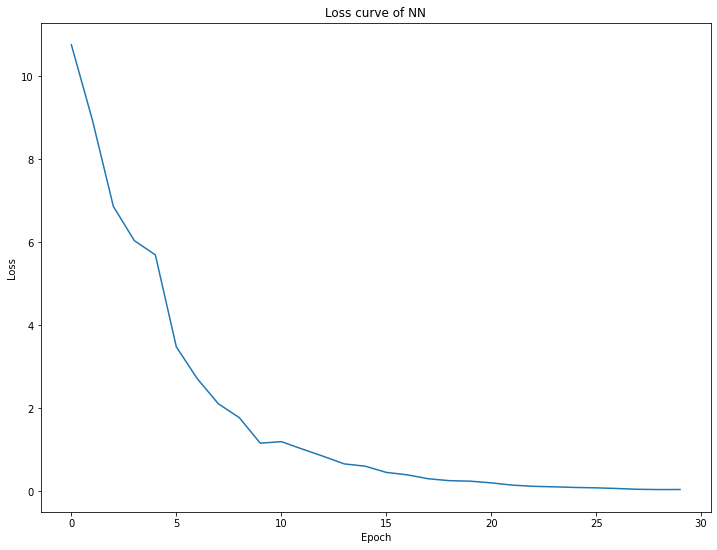

In [42]:
fig = plt.figure(figsize=(12, 9))
plt.plot(np.arange(0, len(losses)), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curve of NN')
plt.show()

Let's evaluate how good our model performs!

In [48]:
def test(model, data):
    r_squares = []
    for X, y in data:
        y_hat = model(X)

        r2 = r2_score(y.detach().cpu().numpy(), y_hat.detach().cpu().numpy())
        r_squares.append(r2)
    
    return np.mean(r_squares)

In [49]:
r2 = test(model, test_loader)
r2

0.9974575774730199

We see, the NN works quite well! Let's see what this tells us. Note that we haven't done any manual feature engineering except for standardization in the dataset. In contrast, in the last section about GLMs we had to manually log-transform some features to enforce a linear relationship between our `X` and `y`. This is not required in DNNs and demonstrates the power of NN to automatically approximate arbitrary functions. 

> **NOTE**: NNs are very good function-approximators. However, don't forget that this comes at some cost: (1) the models tend to get much more complex than simple GLMs and (2) as a consequence NNs are much less interpretable than simpler approaches. For example, how would you try to assess how important a feature is based on the parameters of NNs? Quite hard, isn't it? For GLMs we could simply use the learnt weight as an indicator of importance.

> **NOTE**: In the above model, we selected the LeakyReLU function as our activation function. Of course, we could have used different functions like ReLU, sigmoid or tanh. The choice of the activation function can heavily influence your model's performance and is one of many hyperparameters of our NN which we can tune. In the last years, ReLU and LeakyReLU have turned out to work well across many scenarios, so you can safely start with these as a good starting-point.

## Classification
Now, let's see how we can employ a NN to perform classification. It's very similar to the above task. First, let's define our model again:

In [371]:
class Classificator(nn.Module):

    def __init__(self, in_dim, out_dim, hidden1_dim, hidden2_dim=None):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, hidden1_dim)
        if hidden2_dim is not None:
            self.linear2 = nn.Linear(hidden1_dim, hidden2_dim)
            self.out = nn.Linear(hidden2_dim, out_dim)
        else:
            self.linear2 = None
            self.out = nn.Linear(hidden1_dim, out_dim)

    def forward(self, x):
        if self.linear2 is None:
            x = F.leaky_relu(self.linear1(x), 0.01)
            return F.log_softmax(self.out(x), dim=1)
        else:
            x = F.leaky_relu(self.linear1(x), 0.01)
            x = F.leaky_relu(self.linear2(x), 0.01)
            return F.log_softmax(self.out(x), dim=1)

As you can see, the model is very similar to the one above (essentially it's the same). But how can we perform classification if our model outputs a linear transformation of the hidden node's values? Shouldn't we have something like the sigmoid again transforming our output to $[0, 1]$? Indeed, we already have it. You don't see it here, however pytorch will take care of this if we select the correct loss-function to optimize our model. We will make use of the `CrossEntropyLoss` which is a generalization of the simple `CrossEntropyLoss` we saw in the last section. This time, it supports an arbitrary number of classes. Pytorch will apply the `softmax`-function to our model-output before computing the loss. The `softmax`-function is defined as follows:
\begin{equation}
\text{softmax}_i(x) = \frac{e^{x_i}}{\sum_i e^{x_i}}
\end{equation}
It returns a probability distribution over $n$ classes, assigning each class $i$ a probability weight according to the output $x_i$ hat was assigned to class $i$ by the NN.

In [372]:
class CreditData(Dataset):

    def __init__(self, root_dir, subset='train') -> None:
        super().__init__()
        self.root_dir = root_dir
        self.subset = subset
        assert subset == 'train' or subset == 'test'
        self._load_data()

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def _load_data(self):
        df = pd.read_csv(self.root_dir + self.subset + '.csv', index_col=0)
        # extract labels
        y = df['target'].to_numpy()
        X = df.drop(columns=['target']).to_numpy()

        x_scaler = StandardScaler()
        X_trans = x_scaler.fit_transform(X)
        self.X = torch.FloatTensor(X_trans)
        self.y = torch.LongTensor(y)

In [373]:
train_set = CreditData('../data/credit-data/', 'train')
test_set = CreditData('../data/credit-data/', 'test')
train_loader = DataLoader(train_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

In [451]:
model = Classificator(17, 3, 10)
optimizer = torch.optim.SGD(model.parameters(), 0.01, momentum=0.9)
loss = nn.CrossEntropyLoss(torch.tensor([0.9, 0.7, 0.9]))

In [452]:
def train_epoch(model, data_loader, optim, loss):
    running_loss = 0
    for X, y in data_loader:
        optim.zero_grad() # reset gradients, important!

        y_hat = model(X) # forward pass
        l = loss(input=y_hat, target=y)
        l.backward() # backward pass
        optim.step()
        running_loss += l.item() / len(data_loader)
    return running_loss

In [453]:
losses = []
for e in range(0, 150):
    epoch_loss = train_epoch(model, train_loader, optimizer, loss)
    print(f"Loss in epoch {e}: {epoch_loss}")
    losses.append(epoch_loss)

Loss in epoch 0: 1.0967831100736345
Loss in epoch 1: 0.9866831877401898
Loss in epoch 2: 0.9294568278959819
Loss in epoch 3: 0.8868157523018972
Loss in epoch 4: 0.865027442574501
Loss in epoch 5: 0.8518403662102563
Loss in epoch 6: 0.8418551683425903
Loss in epoch 7: 0.8338421838624138
Loss in epoch 8: 0.8272298063550677
Loss in epoch 9: 0.821887080158506
Loss in epoch 10: 0.8175233517374311
Loss in epoch 11: 0.8136957628386363
Loss in epoch 12: 0.8101265962634767
Loss in epoch 13: 0.807194803442274
Loss in epoch 14: 0.8044413434607641
Loss in epoch 15: 0.802095509001187
Loss in epoch 16: 0.8001869682754789
Loss in epoch 17: 0.7984264748437063
Loss in epoch 18: 0.7969815496887478
Loss in epoch 19: 0.7957421434777122
Loss in epoch 20: 0.7946325348956244
Loss in epoch 21: 0.7936391127961021
Loss in epoch 22: 0.7927355212824686
Loss in epoch 23: 0.7919049667460576
Loss in epoch 24: 0.7911954309259142
Loss in epoch 25: 0.7905051772083557
Loss in epoch 26: 0.7899410405329295
Loss in epoch 2

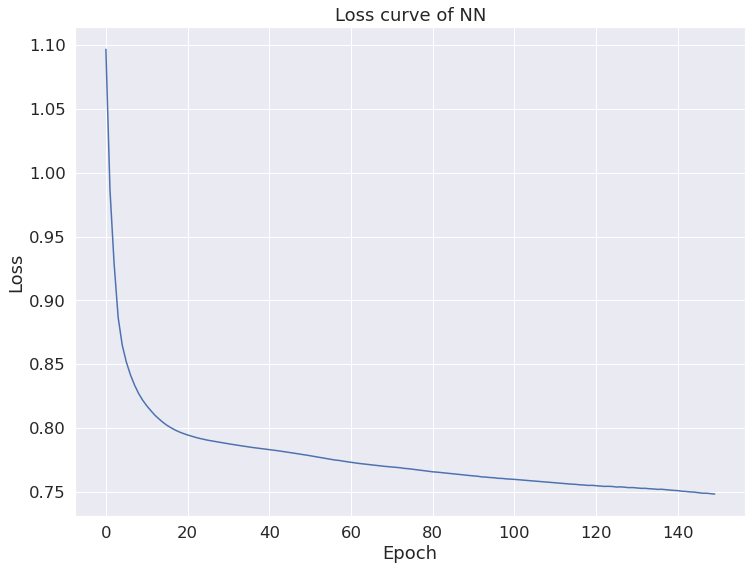

In [454]:
fig = plt.figure(figsize=(12, 9))
plt.plot(np.arange(0, len(losses)), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curve of NN')
plt.show()

In [455]:
def test(model, data):
    accs, f1s = [], []
    conf_mat = None
    for x, y in data:
        y_hat = F.softmax(model(x), dim=1)
        cls = torch.argmax(y_hat, dim=1)

        cm = confusion_matrix(y, cls)
        if conf_mat is None:
            conf_mat = cm
        else:
            conf_mat += cm

        acc = accuracy_score(y.detach().cpu().numpy(), cls.detach().cpu().numpy())
        f1 = f1_score(y.detach().cpu().numpy(), cls.detach().cpu().numpy(), average='macro')

        accs.append(acc)
        f1s.append(f1)
    return np.mean(accs), np.mean(f1s), conf_mat

In [456]:
acc, f1, conf_mat = test(model, test_loader)

<AxesSubplot:>

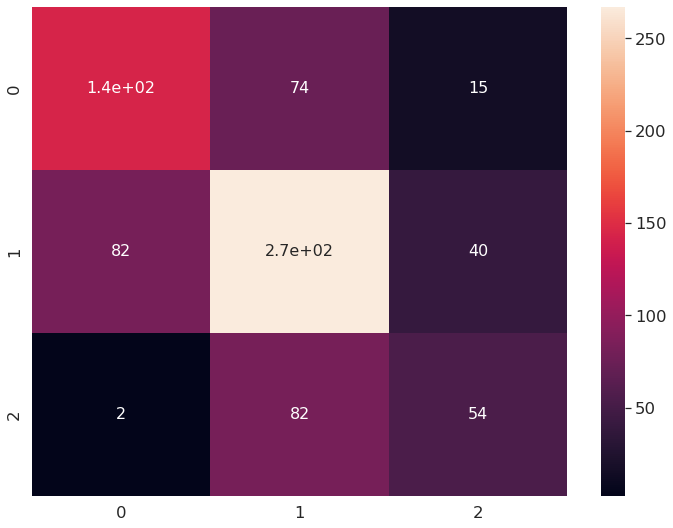

In [457]:
df = pd.DataFrame(data=conf_mat)
fig = plt.figure(figsize=(12, 9))
sns.set(font_scale=1.5)
sns.heatmap(df, annot=True, annot_kws={"size": 16})

In [458]:
acc

0.6107717803030303

In [442]:
f1

0.5632061837349882

We see that the NN does not work very well on this dataset. We esepcially obtain many misclassifications where the NN predicts class 1 although it should be class 2. What can we do about this? Either we tune the network's architecture and hyperparameters or we try to balance the class-weights. Try the first one first (it's easy to do).

In [ ]:
# load data
data = pd.read_csv('../data/credit-data/prepared_data.csv', index_col=0)

# extract labels
y = data['Credit_Score'].to_numpy()
X = data.drop(columns=['Credit_Score']).to_numpy()

In [397]:
print(f"Weight c1: {len(y[y == 0]) / len(y)}")
print(f"Weight c2: {len(y[y == 1]) / len(y)}")
print(f"Weight c3: {len(y[y == 2]) / len(y)}")

Weight c1: 0.2986550632911392
Weight c2: 0.524129746835443
Weight c3: 0.17721518987341772


Let's summarize: In this section we have seen how to use DNNs (in particular MLPs) to perform regression and classification tasks. We obtained that in our case, a MLP works very well for regression while it's not working that well in our classification-task. However, note that this is no general statement! That said, NNs are function approximators, they don't favour regression tasks over classification tasks and vice versa. 

Lessons learned with DNNs:
1. They can achieve greate performances
2. They are hard(er) to debug and interpret
3. simpler models sometimes achieve better results while being interpretable (especially on tabular data)

One last statement you should be aware of every time you plan to use ML: **Try simple methods first, then go for complex ones!**